# Converting BDTNS dates to Processed Dates

The purpose of this notebook is to take the dates from the Drehem dataset and convert to dates that are easier to work with. The 0th date in the processed dates is the beginning of Ur-Namma's period. 

Notebook by Tiffany Chien for the Sumerian Network project.

# 1. Getting text file from BDTNS

In order to get P numbers and dates, go to 
http://bdtns.filol.csic.es/ 

In the Catalogue & Transliteration drop down menu choose "Search" 

In the Search form go to Provenience (another drop down menu) and choose Puzrish-Dagan (the ancient name of Drehem) and hit "Search". This will yield a long list of all tablets from Drehem - some 15,000 of them. In the left pane there is an Export button. Once you hit the button you get a number of options. Select "CDLI number" (= P number) and Date and hit "export". This will produce a .txt file that you can manipulate further.


Importing information from text file as a dataframe

In [3]:
import pandas as pd
TEXT_FILE_PATH = "bdtns_metadata/query_cat_19_09_20-071746.txt"
drehem_date_data = pd.read_csv(TEXT_FILE_PATH, delimiter='\t', header=None)

Column 1 contains the CDLI numbers and Column 2 contains the unprocessed dates.

In [4]:
drehem_date_data.head(7)

,0,1,2
0,38699,P142785,IS01 - 07 - 00
1,38700,P142787,SS05 - 06 - 12
2,38701,P142788,SH48 - 12 - 20
3,38702,P142789,SS04 - XX - 15
4,38703,P142790,XXXX - 01 - 01
5,38704,P142791,AS06 - 11 - 19
6,38706,P142793,SS07 - 11 - 00


#  2. Removing rows with null dates

In [5]:
dates = drehem_date_data[2]
drehem_date_data = drehem_date_data[~dates.isna()]

Mapping KINGS to years. We subtract the years from the bias as we want processed dates to start from the beginning of Ur-Namma's reigning period as 0. 

The names mapping is not used later in the code but is there to show which abbreviation stands for whom. 

In [6]:
BIAS = 2112

KINGS = {
	'Ur-Namma': (BIAS - 2112, BIAS - 2095),
	'SH': (BIAS - 2094, BIAS - 2047),
	'AS': (BIAS - 2046, BIAS - 2038),
	'SS': (BIAS - 2037, BIAS - 2029),
	'IS': (BIAS - 2028, BIAS - 2004)
}


names = {'IS': 'Ibbi-Suen',
         'SS': 'Shu-Suen',
         'AS': 'Amar-Suen',
         'SH': 'Shulgi',
        }

# 3. Converting months and days to appropriate decimal representation

If any part of the dates has an invalid value, we represent it as 0 in this dataset. The catch_num_formatting function converts a number to its appropriate value for adding to the total date.

For example, **catch_num_formatting(07, '0.')** would return 0.07. This value would then be added to the total date as month. 

To represent month, we call **catch_num_formatting(month, '0.')**.<br />
To represent a day, we call **catch_num_formatting(day, '0.00')**.

Note: Could also choose to exclude it from entire dataset if needed

In [7]:
INVALID_DATES = {'00', '--', '--,', 'XX', '??'}

def catch_num_formatting(number, decimal):
    if number in INVALID_DATES or 'x' in number:
        return 0
    try:
        return float(decimal + number)
    except ValueError:
        print('num formatting', number)
        return 0

Here is an example of converting a singular date to a proccessed date. Splitting the date by '-' and stripping them of white spaces seperates the year, month, and day into 3 strings. 

The processed date is the summation of the year, the converted month, and the converted date. The first two characters of the string contain information about the King(retrieved from the KINGS mapping) and the last two characters specify the amount of years into the king's period. 

In [8]:
a_date = drehem_date_data[2][0].split('-')
print(a_date)
year = a_date[0].strip()
month = a_date[1].strip()
day = a_date[2].strip()


processed = KINGS[year[0:2]][0]+int(year[2:]) + catch_num_formatting(month, '0.') + catch_num_formatting(day, '0.00')
print('processed',processed)

['IS01 ', ' 07 ', ' 00']
processed 85.07


Processing all dates in dataframe from txt file

In [9]:
def process_dates(a_date):
    try:
        if a_date not in INVALID_DATES:
            split_date = a_date.split('-')
            year = process_year(split_date[0])
            month = split_date[1].strip()[0:2]
            day = split_date[2].strip()[0:2]
            processed = year + catch_num_formatting(month, '0.') + catch_num_formatting(day, '0.00')
            return processed
    except:
        print('This date caused an error: ',a_date)
        return 0

def process_year(year):
    try:
        if year[0:2] in INVALID_DATES:
            return 0
        else:
            return KINGS[year[0:2]][0]+int(year[2:])
    except:
        return 0
        
drehem_date_data[3] = drehem_date_data[2].apply(process_dates)
drehem_date_data[drehem_date_data[2]!=0].head()


This date caused an error:  AS08 01 - XX+7
This date caused an error:  IS01 12d - 00
num formatting 0l


,0,1,2,3
0,38699,P142785,IS01 - 07 - 00,85.0700
1,38700,P142787,SS05 - 06 - 12,80.0612
2,38701,P142788,SH48 - 12 - 20,66.1220
3,38702,P142789,SS04 - XX - 15,79.0015
4,38703,P142790,XXXX - 01 - 01,0.0101


In [10]:
#adding column names
drehem_date_data.rename(columns={0: 'BDTNS No', 1: 'CDLI No', 2: 'Original date', 3:'Converted Date'}, inplace = True)
drehem_date_data.head(3)

,BDTNS No,CDLI No,Original date,Converted Date
0,38699,P142785,IS01 - 07 - 00,85.0700
1,38700,P142787,SS05 - 06 - 12,80.0612
2,38701,P142788,SH48 - 12 - 20,66.1220


# 4. Writing to CSV

In [14]:
drehem_date_data.to_csv("bdtns_metadata/dates.csv")

In [15]:
#outlier
#removed from dataset for visualization purposes

print('Removed the following rows in visualization:')
print(drehem_date_data[drehem_date_data['Converted Date']>400])
drehem_date_data = drehem_date_data[drehem_date_data['Converted Date']<400]



Removed the following rows in visualization:
Empty DataFrame
Columns: [BDTNS No, CDLI No, Original date, Converted Date]
Index: []


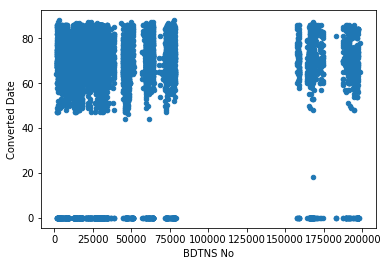

In [16]:
ax = drehem_date_data.plot.scatter(x=0, 
                                   y = 'Converted Date',)